#Setup

##Google Drive

In [1]:
!pip install sportsreference
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

     |████████████████████████████████| 378kB 9.1MB/s 


##Import Packages

In [0]:
import pickle
import pandas as pd
import numpy as np
from sportsreference.nba.teams import Teams
from sportsreference.nba.roster import Roster
from sportsreference.nba.roster import Player
from sportsreference.nba.boxscore import Boxscore
from sklearn.utils import shuffle
from statsmodels.formula.api import logit
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
np.random.seed(123)

##Download files

In [3]:
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data/pickle/')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1e8GS0L0xUXQDgiRorx__FQViQjHNza7c' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: nba19_schedule.pkl, id: 1dDDb1Z73WN-AdTQsM1uHz3I37J0-pkiO
downloading to /root/data/pickle/nba19_schedule.pkl
title: prob_df.pkl, id: 1hDp9GE3Bka9p9oiCbc8TrXFmnslxb2xz
downloading to /root/data/pickle/prob_df.pkl
title: Simulation_2019_20.xlsx, id: 1wUhiDOCQ1sYVab6GkbXzkBvXyBLbaCz4
downloading to /root/data/pickle/Simulation_2019_20.xlsx
title: logistic_model.pkl, id: 1r9655Pr_rfpAYjUj8Ev84OiNbhzc4TeB
downloading to /root/data/pickle/logistic_model.pkl
title: match_df_processed.pkl, id: 1ntpAAnbKO65Q_T7u-kec809CyURKXavp
downloading to /root/data/pickle/match_df_processed.pkl
title: all_players_data_all_season_processed.pkl, id: 1wuFPczmUxGikAqT-mKlu6uWhZXN9folv
downloading to /root/data/pickle/all_players_data_all_season_processed.pkl
title: all_players_data_all_season.pkl, id: 1Ngu5JnhvdPLE5VPo5LutFfZ2Q5uT9Lgg
downloading to /root/data/pickle/all_players_data_all_season.pkl
title: players_list.pkl, id: 17dLZoeKIEeAcS3ZffJf5kt_xEqUab6Gi
downloading to /root/data/pickle/players_l

#Load Data

##Load data from pickle

In [0]:
# retrieve match data from pickle files
match_df_processed_file = '/root/data/pickle/match_df_processed.pkl'
with open(match_df_processed_file, 'rb') as f:
  match_df = pickle.load(f)

# retrieve players list from pickle files
players_list_file = '/root/data/pickle/players_list.pkl'
with open(players_list_file, 'rb') as f:
  players_list = pickle.load(f)

# retrieve players' stats data from pickle files
all_players_data_all_season_file = '/root/data/pickle/all_players_data_all_season_processed.pkl'
with open(all_players_data_all_season_file, 'rb') as f:
  all_players_data = pickle.load(f)

#Logistic regression for match prediction

##Select columns for model

In [0]:
cols = ['boxscore',
        'PG_home_rating', 
        'SG_home_rating', 
        'SF_home_rating', 
        'PF_home_rating', 
        'C_home_rating', 
        'bench_home_rating',
        'PG_away_rating', 
        'SG_away_rating', 
        'SF_away_rating', 
        'PF_away_rating', 
        'C_away_rating', 
        'bench_away_rating',
        'home_win_flag'    
        ]

match_df_model = match_df[cols].copy()

##Data split

In [0]:
# Shuffle
match_df_model_s = shuffle(match_df_model)

# Split
NBA_train = match_df_model_s[0:int(0.80*match_df_model_s.shape[0])]
NBA_test = match_df_model_s[int(0.80*match_df_model_s.shape[0]):]

##Train model

In [0]:
# # Model Tuning
# model = logit(formula = 'home_win_flag~\
#                         PG_home_rating+SG_home_rating+\
#                         PG_home_rating+SF_home_rating+\
#                         PG_home_rating*PF_home_rating+\
#                         PG_home_rating+C_home_rating+\
#                         SG_home_rating+SF_home_rating+\
#                         SG_home_rating+PF_home_rating+\
#                         SG_home_rating+C_home_rating+\
#                         SF_home_rating+PF_home_rating+\
#                         SF_home_rating+C_home_rating+\
#                         PF_home_rating+C_home_rating+\
#                         bench_home_rating+\
#                         PG_away_rating+SG_away_rating+\
#                         PG_away_rating+SF_away_rating+\
#                         PG_away_rating*PF_away_rating+\
#                         PG_away_rating+C_away_rating+\
#                         SG_away_rating+SF_away_rating+\
#                         SG_away_rating+PF_away_rating+\
#                         SG_away_rating+C_away_rating+\
#                         SF_away_rating+PF_away_rating+\
#                         SF_away_rating+C_away_rating+\
#                         PF_away_rating+C_away_rating+\
#                         bench_away_rating', data = NBA_train).fit()

# print(model.summary())

In [0]:
# Tuned model
model = logit(formula = 'home_win_flag~\
                        PG_home_rating+\
                        SG_home_rating+\
                        SF_home_rating+\
                        PF_home_rating+\
                        C_home_rating+\
                        bench_home_rating+\
                        PG_home_rating:PF_home_rating+\
                        PG_away_rating+\
                        SG_away_rating+\
                        SF_away_rating+\
                        PF_away_rating+\
                        C_away_rating+\
                        bench_away_rating+\
                        PG_away_rating:PF_away_rating', data = NBA_train).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.629826
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          home_win_flag   No. Observations:                 9342
Model:                          Logit   Df Residuals:                     9327
Method:                           MLE   Df Model:                           14
Date:                Sun, 01 Dec 2019   Pseudo R-squ.:                 0.07048
Time:                        04:41:11   Log-Likelihood:                -5883.8
converged:                       True   LL-Null:                       -6330.0
Covariance Type:            nonrobust   LLR p-value:                1.957e-181
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.5066      0.556     -0.912      0.

##Save model to pickle

In [0]:
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# save to drive
link = 'https://drive.google.com/open?id=1e8GS0L0xUXQDgiRorx__FQViQjHNza7c'
_, id = link.split("=")

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': id}]})
file.SetContentFile('logistic_model.pkl')
file.Upload() 

##Load model from pickle

In [0]:
# retrieve players' stats data from pickle files
model_file = '/root/data/pickle/logistic_model.pkl'
with open(model_file, 'rb') as f:
  model = pickle.load(f)

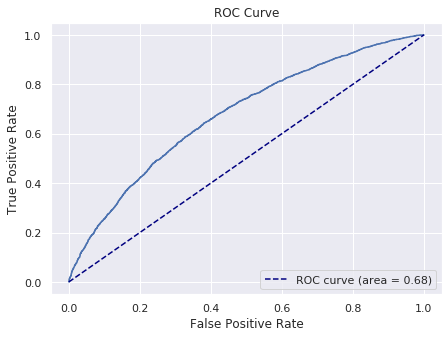

In [0]:
predictions = model.predict(NBA_train)

fpr, tpr, thresholds = roc_curve(NBA_train['home_win_flag'], predictions)
roc_auc = auc(fpr, tpr)

sns.set(rc={'figure.figsize':(7,5)})

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

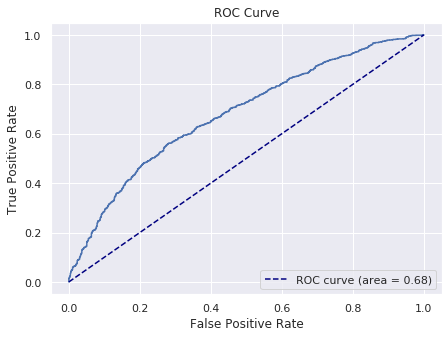

In [0]:
predictions = model.predict(NBA_test)

fpr, tpr, thresholds = roc_curve(NBA_test['home_win_flag'], predictions)
roc_auc = auc(fpr, tpr)

sns.set(rc={'figure.figsize':(7,5)})

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()